<a href="https://colab.research.google.com/github/alivarastepour/Random-Network-Distillation/blob/master/rnd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stable-baselines3 gymnasium[atari]
!pip install "gymnasium[accept-rom-license, atari]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446661 sha256=3f5a8bf1e6a588a3785e552ae934b24858668e0247a4c3374c20fb186fa0b595
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [2]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import torch.nn as nn

In [3]:
!apt-get install xvfb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [4]:
!apt-get install python-opengl ffmpeg
!apt-get update
!apt-get install cmake
!pip install ez_setup
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,499 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 http://archive.ubuntu.com/ubuntu 

In [5]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [19]:
from random import randint
# Custom neural network class (RND or other)
class CustomNetwork(nn.Module):
    def __init__(self, input_shape, output_dim):
        super(CustomNetwork, self).__init__()
        # Define your network architecture here

    def forward(self, x):
        # Define the forward pass
        pass

# Custom callback for modifying rewards
class CustomRewardCallback(BaseCallback):
    def __init__(self, rnd_predictor, rnd_target, verbose=0):
        super(CustomRewardCallback, self).__init__(verbose)
        self.rnd_predictor = rnd_predictor
        self.rnd_target = rnd_target

    def _on_step(self) -> bool:
        # Access observations and modify rewards
        # print(self.locals.keys())
        observation = self.locals["obs_tensor"]
        rew = self.locals["rewards"]
        new_rew = randint(0, 5)
        self.locals["rewrads"] = new_rew + rew
        # print("observation ",observation)
        # print("reward ", rew)
        # Custom reward logic here
        return True

# Main setup
env = gym.make("ALE/FlagCapture-v5", render_mode="rgb_array")
model = PPO("CnnPolicy", env, verbose=1)


# Create and pass the callback
callback = CustomRewardCallback(None, None)

# Training the model with custom callback


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [20]:
model.learn(total_timesteps=3, callback=callback)
model.save("CnnPolicy")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.16e+03 |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 99       |
|    iterations      | 1        |
|    time_elapsed    | 20       |
|    total_timesteps | 2048     |
---------------------------------


In [9]:
import glob
import io
import base64
from IPython.display import HTML

In [27]:
# Save the model

# Load the model
model = PPO.load("CnnPolicy",env=env)

vec_env = model.get_env()
obs = vec_env.reset()
frames = []

for i in range(1000):
    action, _states = model.predict(obs)
    print(action)
    # print(_states)
    resa = vec_env.step(action)
    frame = vec_env.render()
    frames.append(frame)

# env.close()
# vec_env.close()
# show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
[14]
[13]
[8]
[1]
[15]
[14]
[3]
[13]
[15]
[7]
[3]
[15]
[7]
[8]
[0]
[8]
[4]
[11]
[10]
[12]
[0]
[0]
[4]
[1]
[4]
[11]
[8]
[9]
[15]
[8]
[5]
[13]
[3]
[12]
[17]
[17]
[11]
[12]
[6]
[11]
[1]
[4]
[15]
[9]
[6]
[15]
[17]
[11]
[17]
[10]
[2]
[14]
[5]
[14]
[12]
[8]
[5]
[13]
[9]
[14]
[15]
[2]
[0]
[17]
[1]
[1]
[7]
[8]
[13]
[11]
[14]
[3]
[8]
[15]
[0]
[7]
[1]
[17]
[14]
[3]
[11]
[17]
[6]
[0]
[16]
[4]
[10]
[8]
[11]
[4]
[11]
[0]
[14]
[5]
[13]
[2]
[8]
[13]
[16]
[3]
[12]
[16]
[6]
[16]
[8]
[0]
[1]
[2]
[15]
[16]
[5]
[15]
[6]
[10]
[10]
[4]
[1]
[9]
[15]
[5]
[6]
[8]
[3]
[3]
[11]
[4]
[1]
[4]
[1]
[17]
[12]
[3]
[6]
[12]
[16]
[7]
[14]
[3]
[16]
[6]
[7]
[2]
[2]
[2]
[11]
[1]
[11]
[16]
[15]
[8]
[4]
[2]
[15]
[1]
[12]
[7]
[0]
[14]
[2]
[16]
[17]
[0]
[14]
[17]
[6]
[14]
[9]
[7]
[9]
[4]
[15]
[2]
[6]
[16]
[0]
[2]
[15]
[7]
[16]
[16]
[10]
[16]
[7]
[0]
[13]
[16]
[0]
[0]
[3]
[12]
[17]
[8]
[11]
[9]
[12]
[16]
[10]
[17

In [ ]:
env.close()

/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


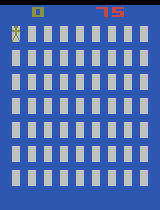

In [28]:
import imageio
# Save the frames as a GIF to display in Colab
imageio.mimsave('/tmp/cartpole.gif', frames, fps=30)

# Display the GIF
from IPython.display import Image
Image(filename='/tmp/cartpole.gif')

In [26]:
len(frames)

1000